Experiment 6: Evaluation of extended DiCE genetic framework

Objective: This code runs an experiment comparing the two counterfactual explanation methods (standard genetic DiCE and physics-guided constrained DiCE). For each test instance, it generates counterfactuals, computes evaluation metrics (validity, DTW proximity, sparsity, diversity, physics residual, runtime), and aggregates the results into a summary table.

In [8]:
import wandb
import warnings
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from dice_ml.explainer_interfaces.explainer_base import UserConfigValidationException
import plotly.graph_objects as go
from datetime import timedelta
import os
import re
import joblib

from scripts.SEP_CFE_DiCE.SEP_CFE_Analyzer import  CFEAnalyzer
from scripts.SEP_CFE_functions import *



min_max_scaler = MinMaxScaler()
warnings.filterwarnings("ignore")

In [2]:
# wandb.init(
#     entity="gsu-dmlab",
#     project="SEPCFE",  # You choose the project name
#     name="Exp6.1_Comparison_PGCE_vs_DiCE",  # Give each run a name
# )

In [2]:
abt_path_train = '../data/raw/mean_sliced/train_data.csv'
df_train = pd.read_csv(abt_path_train,  sep=',',index_col=0)
abt_path_test = '../data/raw/mean_sliced/test_data.csv'
df_test = pd.read_csv(abt_path_test, sep=',',index_col=0)
abt_path_val = '../data/raw/mean_sliced/valid_data.csv'
df_val = pd.read_csv(abt_path_val, sep=',',index_col=0)
X_train=pd.read_csv('../data/processed/X_train.csv',sep=',',index_col=0)
Y_train=pd.read_csv('../data/processed/Y_train.csv',sep=',',index_col=0)
X_test=pd.read_csv('../data/processed/X_test.csv',sep=',',index_col=0)
Y_test=pd.read_csv('../data/processed/Y_test.csv',sep=',',index_col=0)
X_val=pd.read_csv('../data/processed/X_val.csv',sep=',',index_col=0)
Y_val=pd.read_csv('../data/processed/Y_val.csv',sep=',',index_col=0)
df_multi_labels = pd.read_excel("../data/raw/multi_labels.xlsx",header=0)
df_multi_labels = df_multi_labels[df_multi_labels['File'] != '1991-06-18_23-16.csv']
df_combined_labels=pd.read_csv('../data/processed/df_combined_labels.csv',sep=',',index_col=0)


In [3]:
# Load model
best_rf = joblib.load('../models/RandomForestClassifier_model_sep_cfe.pkl')
exp_random = joblib.load("../models/sep_cfe_random_explainer.pkl")
exp_genetic = joblib.load("../models/sep_cfe_genetic_explainer.pkl")

In [4]:
df_cfe = df_test.drop(["Label"],axis=1)
#df_cfe = df_combined_labels.drop(["Label","File","Label.1"],axis=1)  # should contain the target column
cont_features = list(df_combined_labels.drop(["Label","Event_Y_N","File","Multi_Label"],axis=1).columns) #should not contain target column
p3_flux_cols = [col for col in df_train.columns if 'p3_flux_ic_mean' in col]
p5_flux_cols = [col for col in df_train.columns if 'p5_flux_ic_mean' in col]
p7_flux_cols = [col for col in df_train.columns if 'p7_flux_ic_mean' in col]
pattern = r'^(p3_flux_ic_mean|p5_flux_ic_mean|p7_flux_ic_mean|long_mean)@\[(\d+:\d+)\]$'
header_list = df_train.columns.astype(str).str.cat(sep="\t").split()
slices = extract_slices_from_headers(header_list,pattern,"p3_flux_ic_mean")

In [5]:
from dice_ml.explainer_interfaces.dice_genetic import DiceGenetic
import numpy as np
from scipy.spatial.distance import mahalanobis

class ConstrainedDiceGenetic(DiceGenetic):
    def __init__(
        self,
        data_interface,
        model_interface,
        permitted_range_dict,
        class_means,                # dict: class_label -> np.array(mean_vector)
        class_covariances,          # dict: class_label -> np.array(covariance_matrix)
        ordering_penalty=1e4,
        # l0_penalty_weight=0,
        proximity_weight=0.5,
        sparsity_weight=0.5,
        diversity_weight=1.0,
        plausibility_weight=1.0,    # NEW weight for plausibility penalty
        **kwargs
    ):
        super().__init__(data_interface, model_interface, **kwargs)
        self.permitted_range_dict = permitted_range_dict
        self.ordering_penalty = ordering_penalty
        # self.l0_penalty_weight = l0_penalty_weight
        self.proximity_weight = proximity_weight
        self.sparsity_weight = sparsity_weight
        self.diversity_weight = diversity_weight
        self.plausibility_weight = plausibility_weight

        self.class_means = class_means
        self.class_covariances = class_covariances
        # Precompute inverse covariance matrices for efficiency
        self.class_cov_inv = {cls: np.linalg.pinv(cov) for cls, cov in class_covariances.items()}

        # Identify all windows from the permitted_range_dict
        self.windows = []
        for fname in permitted_range_dict:
            if fname.startswith('p3_flux_ic_mean@'):
                window = fname.split('@')[1]
                self.windows.append(window)

        # Build feature name mapping for each window
        self.feature_triplets = []
        for window in self.windows:
            p3 = f'p3_flux_ic_mean@{window}'
            p5 = f'p5_flux_ic_mean@{window}'
            p7 = f'p7_flux_ic_mean@{window}'
            if (p3 in data_interface.feature_names and
                p5 in data_interface.feature_names and
                p7 in data_interface.feature_names):
                self.feature_triplets.append((p3, p5, p7))

        # Build index mapping for fast access
        self.feature_indices = []
        for p3, p5, p7 in self.feature_triplets:
            idx3 = data_interface.feature_names.index(p3)
            idx5 = data_interface.feature_names.index(p5)
            idx7 = data_interface.feature_names.index(p7)
            self.feature_indices.append((idx3, idx5, idx7))

    def _ordering_constraint_penalty(self, candidates):
        penalty = np.zeros(candidates.shape[0])
        for idx3, idx5, idx7 in self.feature_indices:
            p3 = candidates[:, idx3]
            p5 = candidates[:, idx5]
            p7 = candidates[:, idx7]
            violations = (p3 >= 10) | (p3 <= p5) | (p5 <= p7)
            penalty += violations.astype(float) * self.ordering_penalty
        return penalty

    def _range_constraint_penalty(self, candidates):
        penalty = np.zeros(candidates.shape[0])
        for fname, (fmin, fmax) in self.permitted_range_dict.items():
            if fname in self.data_interface.feature_names:
                idx = self.data_interface.feature_names.index(fname)
                vals = candidates[:, idx]
                out_of_bounds = (vals < fmin) | (vals > fmax)
                penalty += out_of_bounds.astype(float) * self.ordering_penalty
        return penalty

    # def _l0_penalty(self, candidates, query_instance):
    #     if query_instance.ndim > 1:
    #         query_instance = query_instance.flatten()
    #     diff = candidates != query_instance
    #     l0 = np.sum(diff, axis=1)
    #     return l0 * self.l0_penalty_weight

    def compute_proximity_loss(self, candidates, query_instance):
        # L1 norm
        return np.sum(np.abs(candidates - query_instance), axis=1)

    def compute_sparsity_loss(self, cfs):
        sparsity_loss = np.count_nonzero(cfs - self.x1, axis=1)
        return sparsity_loss / len(self.data_interface.feature_names)

    def compute_diversity_loss(self, candidates):
        from scipy.spatial.distance import pdist
        if candidates.shape[0] < 2:
            return np.zeros(candidates.shape[0])
        dists = pdist(candidates, metric='cityblock')
        mean_div = np.mean(dists)
        return np.full(candidates.shape[0], mean_div)

    def _plausibility_penalty(self, candidates, desired_class):
        # Mahalanobis distance of each candidate to the mean of desired_class
        mean_vec = self.class_means[desired_class]
        cov_inv = self.class_cov_inv[desired_class]
        penalties = np.zeros(candidates.shape[0])
        for i, candidate in enumerate(candidates):
            diff = candidate - mean_vec
            penalties[i] = mahalanobis(candidate, mean_vec, cov_inv)
        # You might scale or threshold this penalty as needed
        return penalties

    def _fitness_fn(self, candidates, query_instance, desired_class, **kwargs):
        # Base fitness from parent (usually y-loss)
        fitness = super()._fitness_fn(candidates, query_instance, desired_class, **kwargs)
        # Add weighted losses
        fitness += self.proximity_weight * self.compute_proximity_loss(candidates, query_instance)
        fitness += self.sparsity_weight * self.compute_sparsity_loss(candidates, query_instance)
        fitness -= self.diversity_weight * self.compute_diversity_loss(candidates)
        # Add custom penalties
        fitness += self._ordering_constraint_penalty(candidates)
        fitness += self._range_constraint_penalty(candidates)
        # fitness += self._l0_penalty(candidates, query_instance)
        # Add plausibility penalty based on Mahalanobis distance
        fitness += self.plausibility_weight * self._plausibility_penalty(candidates, desired_class)
        return fitness


In [6]:
import dice_ml
df_train["Event_Y_N"] = df_train['Label'].replace({0:1, -1:0})
cont_features = list(df_train.drop(["Label","Event_Y_N"],axis=1).columns)
df_cfe = df_train.drop("Label",axis=1)

data= dice_ml.Data(dataframe=df_cfe, continuous_features=cont_features, outcome_name='Event_Y_N')
cfe_model = dice_ml.Model(model=best_rf, backend="sklearn", model_type='classifier')


In [7]:
labels = Y_train.iloc[:, 0].values
# Compute class means and covariances
classes = np.unique(labels)
class_means = {}
class_covariances = {}

for cls in classes:
    X_cls = X_train[labels == cls]
    class_means[cls] = X_cls.mean(axis=0).values
    class_covariances[cls] = np.cov(X_cls.values, rowvar=False, ddof=0)

In [8]:
PBCF_explainer = ConstrainedDiceGenetic(
    data_interface=data,
    model_interface=cfe_model,
    permitted_range_dict={},
    class_means=class_means,
    class_covariances=class_covariances
)


In [9]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
from scipy.spatial.distance import euclidean
from dtaidistance import dtw # for DTW proximity

# ----------------------------
# 1. Setup
# ----------------------------

# Assume you have:
# - best_rf: trained RandomForest
# - exp: SCF explainer (DiCE-GA)
# - explainer: PBCF explainer (ConstrainedDiceGenetic)
# - query_instances: dataframe of test instances to evaluate

def dtw_distance(x, y):
    """Compute DTW distance between two numpy vectors."""
    d = dtw.distance(x, y)
    return d

def validity(cfs, clf, desired_class):
    """Fraction of CFs classified into desired class."""
    preds = clf.predict(cfs)
    return np.mean(preds == desired_class)

def sparsity(x_orig, x_cf):
    """Fraction of unchanged features (L0)."""
    return np.sum(x_orig != x_cf) / len(x_orig)

def diversity(cfs):
    """Average pairwise L2 distance among CFs."""
    if len(cfs) < 2:
        return 0
    dists = []
    for i in range(len(cfs)):
        for j in range(i+1, len(cfs)):
            dists.append(np.linalg.norm(cfs[i]-cfs[j]))
    return np.mean(dists)

def physics_residual(cfs, constraint_fn):
    """Compute average physics violation per CF (your function)."""
    return np.mean([constraint_fn(cf) for cf in cfs])

In [12]:
# ----------------------------
# 2. Experiment Loop
# ----------------------------

results = []
cf_records_exp = []   # store CFs from exp_orig
cf_records_pb = []    # store CFs from PBCF

df_test_SEP_post_2003 = df_combined_labels.iloc[1970:]
df_random_batch = df_test_SEP_post_2003.sample(n=200, random_state=23).sort_index()

for idx, instance in tqdm(df_random_batch.iterrows(), total=len(df_random_batch)):
# for idx, instance in tqdm(df_test_SEP_post_2003.iterrows(),total=len(df_test_SEP_post_2003)):
    csv_file_name = instance["File"]
    class_label = instance["Event_Y_N"]
    desired_label =int(1-class_label)
    print(f"Class_label: {class_label},Desired_label:{desired_label}")
    x_orig = instance.drop(["Label", "Event_Y_N", "Multi_Label", "File"]).values.reshape(1, -1)

    for method_name, expl in [("exp_orig", exp_genetic), ("PBCF", PBCF_explainer)]:
        start = time.time()

        try:
            # Generate CFs
            cf_obj = expl.generate_counterfactuals(
                query_instances=instance.drop(["Label", "Event_Y_N", "Multi_Label", "File"]).to_frame().T,
                total_CFs=1,          # k=5 CFs
                desired_class=desired_label        # target class
                # desired_class=1
            )

            if cf_obj is None :
                print(f"No counterfactuals found for instance {idx}")
                continue

            end = time.time()
            # Extract CF array
            cfs_df = cf_obj.cf_examples_list[0].final_cfs_df.drop("Event_Y_N", axis=1)
            cfs = cfs_df.values

        except IndexError:
            print(f"⚠️ DiCE failed for instance {idx}: empty population")
            continue
        except Exception as e:
            print(f"⚠️ Unexpected error at instance {idx}: {e}")
            continue

        if len(cfs) == 0:
            results.append({
                "instance_id": idx,
                "method": method_name,
                "validity": 0,
                "dtw": np.nan,
                "sparsity": np.nan,
                "diversity": np.nan,
                "physics_residual": np.nan,
                "runtime": end-start
            })
            continue

        # ---------------- Metrics ----------------
        val = validity(cfs, best_rf, desired_class=1)
        dtw_vals = [dtw_distance(x_orig.flatten(), cf) for cf in cfs]
        sparsity_vals = [sparsity(x_orig.flatten(), cf) for cf in cfs]
        div = diversity(cfs)
        phys = physics_residual(cfs, constraint_fn=lambda cf: 0)  # <-- replace with your physics check

        # Aggregate per instance
        results.append({
            "instance_id": idx,
            "method": method_name,
            "validity": val,
            "dtw": np.mean(dtw_vals),
            "sparsity": np.mean(sparsity_vals),
            "diversity": div,
            "physics_residual": phys,
            "runtime": end-start
        })

        # ---------------- Collect CFs ----------------
        cfs_df["instance_id"] = idx
        cfs_df["method"] = method_name
        cfs_df["filename"] = csv_file_name
        cfs_df["class_label"]=class_label
        if method_name == "exp_orig":
            cf_records_exp.append(cfs_df)
        else:
            cf_records_pb.append(cfs_df)

# ----------------------------
# 3. Results DataFrames
# ----------------------------
results_df = pd.DataFrame(results)

# Aggregate across all instances
summary = results_df.groupby("method").agg({
    "validity": ["mean", "std"],
    "dtw": ["mean", "std"],
    "sparsity": ["mean", "std"],
    "diversity": ["mean", "std"],
    "physics_residual": ["mean", "std"],
    "runtime": ["mean", "std"]
})

print(summary)

# Two DataFrames with CFs
exp_cfs_df = pd.concat(cf_records_exp, ignore_index=True)
pb_cfs_df = pd.concat(cf_records_pb, ignore_index=True)

print("exp_orig CFs shape:", exp_cfs_df.shape)
print("PBCF CFs shape:", pb_cfs_df.shape)


  0%|          | 0/200 [00:00<?, ?it/s]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:05<00:00,  5.12s/it]

  0%|          | 1/200 [00:13<43:16, 13.05s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:03<00:00,  3.24s/it]

  1%|          | 2/200 [00:26<43:23, 13.15s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:06<00:00,  6.54s/it]

  2%|▏         | 3/200 [00:49<58:23, 17.79s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:07<00:00,  7.83s/it]

  2%|▏         | 4/200 [01:08<59:03, 18.08s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:06<00:00,  6.12s/it]

  2%|▎         | 5/200 [01:25<57:54, 17.82s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.70s/it]

  3%|▎         | 6/200 [01:34<47:32, 14.71s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

  4%|▎         | 7/200 [01:42<40:51, 12.70s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

  4%|▍         | 8/200 [01:50<36:00, 11.25s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.68s/it]

  4%|▍         | 9/200 [01:59<32:56, 10.35s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.67s/it]

  5%|▌         | 10/200 [02:07<30:48,  9.73s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.81s/it]

  6%|▌         | 11/200 [02:16<29:43,  9.43s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.59s/it]

  6%|▌         | 12/200 [02:26<30:04,  9.60s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:03<00:00,  3.17s/it]

  6%|▋         | 13/200 [02:39<33:29, 10.74s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:05<00:00,  5.66s/it]

  7%|▋         | 14/200 [02:52<35:43, 11.52s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.44s/it]

  8%|▊         | 15/200 [02:59<31:18, 10.15s/it]

⚠️ DiCE failed for instance 2044: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.63s/it]

  8%|▊         | 16/200 [03:06<27:29,  8.96s/it]

⚠️ DiCE failed for instance 2049: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.16s/it]

  8%|▊         | 17/200 [03:13<25:52,  8.48s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.32s/it]

  9%|▉         | 18/200 [03:20<24:42,  8.14s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.92s/it]

 10%|▉         | 19/200 [03:28<24:15,  8.04s/it]

⚠️ DiCE failed for instance 2065: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.13s/it]

 10%|█         | 20/200 [03:36<23:29,  7.83s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.31s/it]

 10%|█         | 21/200 [03:43<22:52,  7.67s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

 11%|█         | 22/200 [03:50<22:23,  7.55s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.32s/it]

 12%|█▏        | 23/200 [03:57<22:04,  7.48s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.31s/it]

 12%|█▏        | 24/200 [04:05<21:52,  7.46s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.94s/it]

 12%|█▎        | 25/200 [04:12<21:49,  7.48s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.23s/it]

 13%|█▎        | 26/200 [04:19<21:20,  7.36s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.25s/it]

 14%|█▎        | 27/200 [04:27<21:11,  7.35s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.12s/it]

 14%|█▍        | 28/200 [04:34<20:56,  7.30s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.31s/it]

 14%|█▍        | 29/200 [04:41<20:46,  7.29s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

 15%|█▌        | 30/200 [04:49<20:50,  7.35s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.14s/it]

 16%|█▌        | 31/200 [04:56<20:36,  7.32s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.01s/it]

 16%|█▌        | 32/200 [05:03<20:18,  7.25s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.32s/it]

 16%|█▋        | 33/200 [05:11<20:25,  7.34s/it]

Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:02<00:00,  2.23s/it]

 17%|█▋        | 34/200 [05:41<39:30, 14.28s/it]

⚠️ Unexpected error at instance 2131: No counterfactuals found for any of the query points! Kindly check your configuration.
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

 18%|█▊        | 35/200 [05:47<32:17, 11.74s/it]

⚠️ DiCE failed for instance 2136: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

 18%|█▊        | 36/200 [05:53<27:10,  9.95s/it]

⚠️ DiCE failed for instance 2137: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.09s/it]

 18%|█▊        | 37/200 [06:00<24:50,  9.15s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.30s/it]

 19%|█▉        | 38/200 [06:07<23:03,  8.54s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.47s/it]

 20%|█▉        | 39/200 [06:16<23:15,  8.67s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:04<00:00,  4.80s/it]

 20%|██        | 40/200 [06:27<24:49,  9.31s/it]

Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:02<00:00,  2.17s/it]

 20%|██        | 41/200 [06:58<42:10, 15.92s/it]

⚠️ Unexpected error at instance 2167: No counterfactuals found for any of the query points! Kindly check your configuration.
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.45s/it]

 21%|██        | 42/200 [07:06<35:49, 13.60s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.44s/it]

 22%|██▏       | 43/200 [07:16<32:37, 12.47s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.32s/it]

 22%|██▏       | 44/200 [07:24<28:50, 11.09s/it]

Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:02<00:00,  2.17s/it]

 22%|██▎       | 45/200 [07:56<44:56, 17.40s/it]

⚠️ Unexpected error at instance 2177: No counterfactuals found for any of the query points! Kindly check your configuration.
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

 23%|██▎       | 46/200 [08:02<35:27, 13.82s/it]

⚠️ DiCE failed for instance 2178: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:03<00:00,  3.31s/it]

 24%|██▎       | 47/200 [08:12<32:16, 12.66s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:03<00:00,  3.55s/it]

 24%|██▍       | 48/200 [08:22<30:03, 11.86s/it]

Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:03<00:00,  3.17s/it]

 24%|██▍       | 49/200 [09:04<53:15, 21.16s/it]

⚠️ Unexpected error at instance 2183: No counterfactuals found for any of the query points! Kindly check your configuration.
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:03<00:00,  3.65s/it]

 25%|██▌       | 50/200 [09:14<44:29, 17.80s/it]

⚠️ DiCE failed for instance 2196: empty population
Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:03<00:00,  3.45s/it]

 26%|██▌       | 51/200 [10:03<1:07:25, 27.15s/it]

⚠️ Unexpected error at instance 2198: No counterfactuals found for any of the query points! Kindly check your configuration.
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:04<00:00,  4.53s/it]

 26%|██▌       | 52/200 [10:16<56:02, 22.72s/it]  

Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:03<00:00,  3.82s/it]

 26%|██▋       | 53/200 [11:05<1:15:12, 30.69s/it]

⚠️ Unexpected error at instance 2206: No counterfactuals found for any of the query points! Kindly check your configuration.
Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:03<00:00,  3.90s/it]

 27%|██▋       | 54/200 [11:54<1:28:19, 36.30s/it]

⚠️ Unexpected error at instance 2208: No counterfactuals found for any of the query points! Kindly check your configuration.
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:03<00:00,  3.90s/it]

 28%|██▊       | 55/200 [12:06<1:10:04, 29.00s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:03<00:00,  3.89s/it]

 28%|██▊       | 56/200 [12:19<57:32, 23.98s/it]  

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.49s/it]

 28%|██▊       | 57/200 [12:25<44:14, 18.57s/it]

⚠️ DiCE failed for instance 2221: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.20s/it]

 29%|██▉       | 58/200 [12:31<35:07, 14.84s/it]

⚠️ DiCE failed for instance 2223: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.77s/it]

 30%|██▉       | 59/200 [12:40<31:02, 13.21s/it]

Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:02<00:00,  2.92s/it]

 30%|███       | 60/200 [13:16<46:35, 19.97s/it]

⚠️ Unexpected error at instance 2238: No counterfactuals found for any of the query points! Kindly check your configuration.
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.47s/it]

 30%|███       | 61/200 [13:23<37:28, 16.18s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

 31%|███       | 62/200 [13:29<30:05, 13.08s/it]

⚠️ DiCE failed for instance 2243: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.28s/it]

 32%|███▏      | 63/200 [13:37<26:12, 11.48s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

 32%|███▏      | 64/200 [13:42<21:47,  9.62s/it]

⚠️ DiCE failed for instance 2250: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.29s/it]

 32%|███▎      | 65/200 [13:49<19:30,  8.67s/it]

⚠️ DiCE failed for instance 2254: empty population
Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

 33%|███▎      | 66/200 [13:54<17:30,  7.84s/it]

⚠️ DiCE failed for instance 2263: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

 34%|███▎      | 67/200 [14:03<18:02,  8.14s/it]

Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:02<00:00,  2.43s/it]

 34%|███▍      | 68/200 [14:35<33:32, 15.25s/it]

⚠️ Unexpected error at instance 2271: No counterfactuals found for any of the query points! Kindly check your configuration.
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.25s/it]

 34%|███▍      | 69/200 [14:44<29:09, 13.36s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.92s/it]

 35%|███▌      | 70/200 [14:52<25:20, 11.70s/it]

Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

 36%|███▌      | 71/200 [15:27<40:22, 18.78s/it]

⚠️ Unexpected error at instance 2289: No counterfactuals found for any of the query points! Kindly check your configuration.
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:03<00:00,  3.09s/it]

 36%|███▌      | 72/200 [15:35<32:58, 15.46s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.61s/it]

 36%|███▋      | 73/200 [15:43<27:45, 13.12s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

 37%|███▋      | 74/200 [15:50<23:53, 11.38s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.33s/it]

 38%|███▊      | 75/200 [15:58<21:29, 10.31s/it]

Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:02<00:00,  2.09s/it]

 38%|███▊      | 76/200 [16:32<36:08, 17.49s/it]

⚠️ Unexpected error at instance 2313: No counterfactuals found for any of the query points! Kindly check your configuration.
Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

 38%|███▊      | 77/200 [17:07<46:45, 22.81s/it]

⚠️ Unexpected error at instance 2314: No counterfactuals found for any of the query points! Kindly check your configuration.
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.11s/it]

 39%|███▉      | 78/200 [17:15<37:07, 18.26s/it]

Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:02<00:00,  2.69s/it]

 40%|███▉      | 79/200 [17:52<48:09, 23.88s/it]

⚠️ Unexpected error at instance 2320: No counterfactuals found for any of the query points! Kindly check your configuration.
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

 40%|████      | 80/200 [17:58<37:25, 18.71s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

 40%|████      | 81/200 [18:05<30:01, 15.14s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

 41%|████      | 82/200 [18:11<24:13, 12.32s/it]

⚠️ DiCE failed for instance 2336: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

 42%|████▏     | 83/200 [18:18<20:49, 10.68s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

 42%|████▏     | 84/200 [18:24<18:16,  9.45s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

 42%|████▎     | 85/200 [18:32<17:17,  9.02s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.53s/it]

 43%|████▎     | 86/200 [18:40<16:10,  8.52s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.21s/it]

 44%|████▎     | 87/200 [18:47<15:17,  8.12s/it]

Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

 44%|████▍     | 88/200 [19:15<26:27, 14.18s/it]

⚠️ Unexpected error at instance 2376: No counterfactuals found for any of the query points! Kindly check your configuration.
Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

 44%|████▍     | 89/200 [19:43<33:55, 18.33s/it]

⚠️ Unexpected error at instance 2380: No counterfactuals found for any of the query points! Kindly check your configuration.
Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

 45%|████▌     | 90/200 [20:11<38:56, 21.24s/it]

⚠️ Unexpected error at instance 2389: No counterfactuals found for any of the query points! Kindly check your configuration.
Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

 46%|████▌     | 91/200 [20:16<29:46, 16.39s/it]

⚠️ DiCE failed for instance 2390: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

 46%|████▌     | 92/200 [20:22<23:31, 13.07s/it]

⚠️ DiCE failed for instance 2391: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

 46%|████▋     | 93/200 [20:28<19:38, 11.02s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

 47%|████▋     | 94/200 [20:35<17:15,  9.77s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

 48%|████▊     | 95/200 [20:42<15:35,  8.91s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

 48%|████▊     | 96/200 [20:48<13:59,  8.07s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.32s/it]

 48%|████▊     | 97/200 [20:55<13:18,  7.75s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

 49%|████▉     | 98/200 [21:02<12:41,  7.47s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

 50%|████▉     | 99/200 [21:08<12:02,  7.15s/it]

Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:02<00:00,  2.58s/it]

 50%|█████     | 100/200 [21:14<11:15,  6.75s/it]

⚠️ DiCE failed for instance 2417: empty population
Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

 50%|█████     | 101/200 [21:42<21:41, 13.15s/it]

⚠️ Unexpected error at instance 2424: No counterfactuals found for any of the query points! Kindly check your configuration.
Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:02<00:00,  2.44s/it]

 51%|█████     | 102/200 [21:48<17:44, 10.86s/it]

⚠️ DiCE failed for instance 2427: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

 52%|█████▏    | 103/200 [21:57<16:44, 10.35s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.53s/it]

 52%|█████▏    | 104/200 [22:05<15:49,  9.89s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:03<00:00,  3.01s/it]

 52%|█████▎    | 105/200 [22:14<14:48,  9.36s/it]

Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:02<00:00,  2.12s/it]

 53%|█████▎    | 106/200 [22:44<24:41, 15.76s/it]

⚠️ Unexpected error at instance 2448: No counterfactuals found for any of the query points! Kindly check your configuration.
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.62s/it]

 54%|█████▎    | 107/200 [22:50<19:51, 12.81s/it]

⚠️ DiCE failed for instance 2449: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

 54%|█████▍    | 108/200 [22:57<16:51, 11.00s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.56s/it]

 55%|█████▍    | 109/200 [23:04<14:56,  9.85s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.07s/it]

 55%|█████▌    | 110/200 [23:12<13:43,  9.15s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.04s/it]

 56%|█████▌    | 111/200 [23:18<12:31,  8.44s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.86s/it]

 56%|█████▌    | 112/200 [23:26<11:56,  8.14s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

 56%|█████▋    | 113/200 [23:33<11:30,  7.94s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.09s/it]

 57%|█████▋    | 114/200 [23:40<10:53,  7.60s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

 57%|█████▊    | 115/200 [23:48<10:40,  7.54s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.91s/it]

 58%|█████▊    | 116/200 [23:54<10:09,  7.26s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.55s/it]

 58%|█████▊    | 117/200 [24:02<10:11,  7.37s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

 59%|█████▉    | 118/200 [24:09<10:03,  7.36s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.26s/it]

 60%|█████▉    | 119/200 [24:15<09:22,  6.94s/it]

⚠️ DiCE failed for instance 2528: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  2.00s/it]

 60%|██████    | 120/200 [24:22<09:25,  7.07s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.14s/it]

 60%|██████    | 121/200 [24:30<09:21,  7.11s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

 61%|██████    | 122/200 [24:37<09:25,  7.25s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

 62%|██████▏   | 123/200 [24:44<09:10,  7.15s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.69s/it]

 62%|██████▏   | 124/200 [24:50<08:39,  6.83s/it]

⚠️ DiCE failed for instance 2548: empty population
Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:01<00:00,  1.94s/it]

 62%|██████▎   | 125/200 [25:20<17:09, 13.73s/it]

⚠️ Unexpected error at instance 2554: No counterfactuals found for any of the query points! Kindly check your configuration.
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

 63%|██████▎   | 126/200 [25:27<14:30, 11.76s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

 64%|██████▎   | 127/200 [25:33<11:57,  9.82s/it]

⚠️ DiCE failed for instance 2559: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.94s/it]

 64%|██████▍   | 128/200 [25:40<10:48,  9.00s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

 64%|██████▍   | 129/200 [25:46<09:52,  8.35s/it]

Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:02<00:00,  2.75s/it]

 65%|██████▌   | 130/200 [26:16<17:15, 14.80s/it]

⚠️ Unexpected error at instance 2573: No counterfactuals found for any of the query points! Kindly check your configuration.
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.17s/it]

 66%|██████▌   | 131/200 [26:24<14:32, 12.64s/it]

Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:01<00:00,  1.99s/it]

 66%|██████▌   | 132/200 [26:30<11:56, 10.54s/it]

⚠️ DiCE failed for instance 2579: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

 66%|██████▋   | 133/200 [26:37<10:36,  9.50s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.83s/it]

 67%|██████▋   | 134/200 [26:44<09:48,  8.92s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.20s/it]

 68%|██████▊   | 135/200 [26:52<09:18,  8.60s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.15s/it]

 68%|██████▊   | 136/200 [26:59<08:43,  8.18s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.99s/it]

 68%|██████▊   | 137/200 [27:07<08:20,  7.95s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.06s/it]

 69%|██████▉   | 138/200 [27:14<07:57,  7.70s/it]

Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:02<00:00,  2.32s/it]

 70%|██████▉   | 139/200 [27:21<07:33,  7.44s/it]

⚠️ DiCE failed for instance 2613: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.99s/it]

 70%|███████   | 140/200 [27:26<06:53,  6.89s/it]

⚠️ DiCE failed for instance 2615: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.91s/it]

 70%|███████   | 141/200 [27:33<06:46,  6.90s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.80s/it]

 71%|███████   | 142/200 [27:41<06:53,  7.12s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

 72%|███████▏  | 143/200 [27:48<06:40,  7.03s/it]

Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:02<00:00,  2.74s/it]

 72%|███████▏  | 144/200 [28:17<12:47, 13.70s/it]

⚠️ Unexpected error at instance 2628: No counterfactuals found for any of the query points! Kindly check your configuration.
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.98s/it]

 72%|███████▎  | 145/200 [28:22<10:13, 11.15s/it]

⚠️ DiCE failed for instance 2633: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.91s/it]

 73%|███████▎  | 146/200 [28:27<08:27,  9.41s/it]

⚠️ DiCE failed for instance 2643: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.94s/it]

 74%|███████▎  | 147/200 [28:34<07:28,  8.46s/it]

⚠️ DiCE failed for instance 2644: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.14s/it]

 74%|███████▍  | 148/200 [28:41<06:57,  8.03s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.81s/it]

 74%|███████▍  | 149/200 [28:47<06:21,  7.47s/it]

⚠️ DiCE failed for instance 2654: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.16s/it]

 75%|███████▌  | 150/200 [28:54<06:07,  7.35s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

 76%|███████▌  | 151/200 [29:02<06:04,  7.44s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

 76%|███████▌  | 152/200 [29:08<05:44,  7.17s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

 76%|███████▋  | 153/200 [29:16<05:40,  7.25s/it]

Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:02<00:00,  2.03s/it]

 77%|███████▋  | 154/200 [29:44<10:32, 13.74s/it]

⚠️ Unexpected error at instance 2671: No counterfactuals found for any of the query points! Kindly check your configuration.
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.66s/it]

 78%|███████▊  | 155/200 [29:52<08:51, 11.81s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.91s/it]

 78%|███████▊  | 156/200 [29:58<07:32, 10.29s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.72s/it]

 78%|███████▊  | 157/200 [30:05<06:40,  9.30s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

 79%|███████▉  | 158/200 [30:12<05:56,  8.49s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.70s/it]

 80%|███████▉  | 159/200 [30:19<05:32,  8.11s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.98s/it]

 80%|████████  | 160/200 [30:26<05:04,  7.61s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.81s/it]

 80%|████████  | 161/200 [30:33<04:56,  7.61s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

 81%|████████  | 162/200 [30:40<04:37,  7.31s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.06s/it]

 82%|████████▏ | 163/200 [30:48<04:36,  7.46s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

 82%|████████▏ | 164/200 [30:55<04:27,  7.42s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.01s/it]

 82%|████████▎ | 165/200 [31:03<04:24,  7.55s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.10s/it]

 83%|████████▎ | 166/200 [31:10<04:13,  7.45s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.09s/it]

 84%|████████▎ | 167/200 [31:18<04:09,  7.55s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

 84%|████████▍ | 168/200 [31:25<03:53,  7.30s/it]

Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

 84%|████████▍ | 169/200 [31:54<07:14, 14.02s/it]

⚠️ Unexpected error at instance 2738: No counterfactuals found for any of the query points! Kindly check your configuration.
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:03<00:00,  3.03s/it]

 85%|████████▌ | 170/200 [32:02<06:05, 12.18s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

 86%|████████▌ | 171/200 [32:09<05:04, 10.51s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.87s/it]

 86%|████████▌ | 172/200 [32:17<04:30,  9.67s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

 86%|████████▋ | 173/200 [32:22<03:45,  8.34s/it]

⚠️ DiCE failed for instance 2746: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

 87%|████████▋ | 174/200 [32:28<03:21,  7.73s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

 88%|████████▊ | 175/200 [32:34<03:00,  7.23s/it]

⚠️ DiCE failed for instance 2750: empty population
Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:02<00:00,  2.09s/it]

 88%|████████▊ | 176/200 [32:40<02:40,  6.67s/it]

⚠️ DiCE failed for instance 2751: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

 88%|████████▊ | 177/200 [32:47<02:39,  6.92s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.92s/it]

 89%|████████▉ | 178/200 [32:54<02:30,  6.82s/it]

Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:02<00:00,  2.01s/it]

 90%|████████▉ | 179/200 [33:23<04:47, 13.68s/it]

⚠️ Unexpected error at instance 2768: No counterfactuals found for any of the query points! Kindly check your configuration.
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

 90%|█████████ | 180/200 [33:29<03:42, 11.15s/it]

⚠️ DiCE failed for instance 2769: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.07s/it]

 90%|█████████ | 181/200 [33:35<03:07,  9.87s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.15s/it]

 91%|█████████ | 182/200 [33:43<02:46,  9.25s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.12s/it]

 92%|█████████▏| 183/200 [33:49<02:18,  8.15s/it]

⚠️ DiCE failed for instance 2788: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

 92%|█████████▏| 184/200 [33:56<02:03,  7.72s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.98s/it]

 92%|█████████▎| 185/200 [34:04<01:57,  7.87s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

 93%|█████████▎| 186/200 [34:11<01:46,  7.59s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.91s/it]

 94%|█████████▎| 187/200 [34:18<01:38,  7.60s/it]

Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:01<00:00,  1.99s/it]

 94%|█████████▍| 188/200 [34:24<01:23,  6.92s/it]

⚠️ DiCE failed for instance 2825: empty population
Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:02<00:00,  2.01s/it]

 94%|█████████▍| 189/200 [34:29<01:11,  6.46s/it]

⚠️ DiCE failed for instance 2831: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.98s/it]

 95%|█████████▌| 190/200 [34:37<01:08,  6.88s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  2.00s/it]

 96%|█████████▌| 191/200 [34:43<01:00,  6.78s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.04s/it]

 96%|█████████▌| 192/200 [34:50<00:54,  6.78s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.85s/it]

 96%|█████████▋| 193/200 [34:58<00:49,  7.01s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.91s/it]

 97%|█████████▋| 194/200 [35:04<00:41,  6.89s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

 98%|█████████▊| 195/200 [35:12<00:35,  7.11s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

 98%|█████████▊| 196/200 [35:17<00:26,  6.54s/it]

⚠️ DiCE failed for instance 2865: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

 98%|█████████▊| 197/200 [35:24<00:19,  6.53s/it]

Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:02<00:00,  2.93s/it]

 99%|█████████▉| 198/200 [35:30<00:12,  6.45s/it]

⚠️ DiCE failed for instance 2871: empty population
Class_label: 0.0,Desired_label:1



100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

100%|█████████▉| 199/200 [35:37<00:06,  6.49s/it]

Class_label: 1.0,Desired_label:0



100%|██████████| 1/1 [00:02<00:00,  2.07s/it]

100%|██████████| 200/200 [36:07<00:00, 10.84s/it]


⚠️ Unexpected error at instance 2879: No counterfactuals found for any of the query points! Kindly check your configuration.
         validity                 dtw            sparsity           diversity  \
             mean       std      mean        std     mean       std      mean   
method                                                                          
PBCF         1.00  0.000000  3.934040   8.146873  1.00000  0.000000       0.0   
exp_orig     0.83  0.376575  7.707704  10.659818  0.99083  0.025376       0.0   

              physics_residual        runtime            
          std             mean  std      mean       std  
method                                                   
PBCF      0.0              0.0  0.0  3.313484  1.030566  
exp_orig  0.0              0.0  0.0  2.481280  0.822875  
exp_orig CFs shape: (200, 932)
PBCF CFs shape: (137, 932)


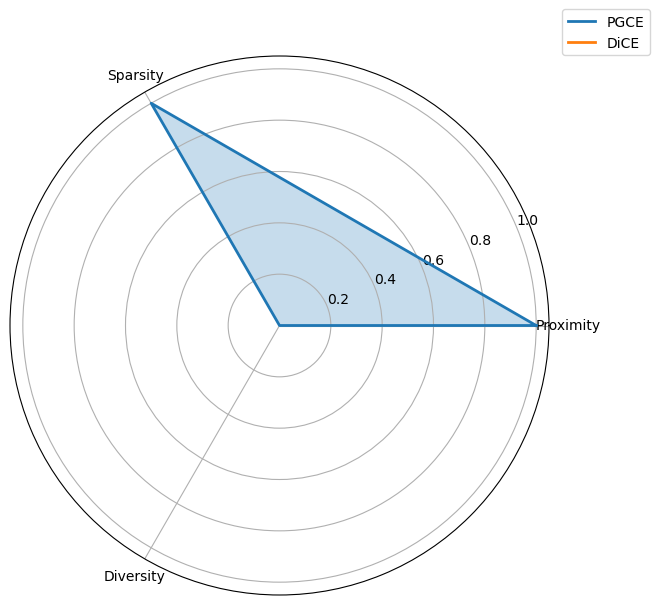

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Your results (mean values only)
data = {
    "Proximity": {"PGCE": 3.934040, "DiCE": 7.707704},          # lower = better
    "Sparsity": {"PGCE": 1.00000, "DiCE": 0.99083},
    "Diversity": {"PGCE": 0, "DiCE": 0}
    # "Runtime": {"PBCF": 3.619628, "exp_orig": 6.986889}        # lower = better
}

df = pd.DataFrame(data)

# Invert metrics where "lower is better"
df_inverted = df.copy()
df_inverted["Proximity"] = -df_inverted["Proximity"]
# df_inverted["runtime"] = -df_inverted["runtime"]

# Normalize (0–1) so they’re comparable
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_inverted),
    index=df.index,
    columns=df.columns
)

# Radar plot setup
categories = df_scaled.columns.tolist()
N = len(categories)
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

for method in df_scaled.index:
    values = df_scaled.loc[method].tolist()
    values += values[:1]
    ax.plot(angles, values, label=method, linewidth=2)
    ax.fill(angles, values, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
# ax.set_title("Radar Plot (Higher = Better on All Metrics)", size=14)
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

window_size = 10  # Smoothing window

fig, axs = plt.subplots(5, 2, figsize=(28, 30), facecolor='white')
axs = axs.flatten()  # Flatten for easy iteration
i=0
cfe_idx=0
while i<10 and cfe_idx<len(pb_cfs_df):
    if pb_cfs_df.iloc[cfe_idx] is not None:
        csv_path = os.path.join('../data/raw/data/', pb_cfs_df.iloc[cfe_idx]["filename"])
        # class_label = pb_cfs_df.iloc[cfe_idx]["class_label"]
        sample_cfe = pb_cfs_df.iloc[cfe_idx].drop(["filename","method","instance_id"])

        # p3
        flux_type = 'p3_flux_ic'
        df_obs, final_series_p3, original_p3, min_y_p3, max_y_p3 = get_pertubed_series(
            csv_path, sample_cfe=sample_cfe, flux_type=flux_type, slices=slices,
            start_offset_min=300, end_offset_min=660)
        original_p3_smooth = original_p3.rolling(window=window_size, center=True).mean()
        final_series_p3_smooth = pd.Series(final_series_p3).rolling(window=window_size, center=True).mean()

        # p5
        flux_type = 'p5_flux_ic'
        df_obs_1, final_series_p5, original_p5, min_y_p5, max_y_p5 = get_pertubed_series(
            csv_path, sample_cfe=sample_cfe, flux_type=flux_type, slices=slices,
            start_offset_min=300, end_offset_min=660)
        original_p5_smooth = original_p5.rolling(window=window_size, center=True).mean()
        final_series_p5_smooth = pd.Series(final_series_p5).rolling(window=window_size, center=True).mean()

        # p7
        flux_type = 'p7_flux_ic'
        df_obs_2, final_series_p7, original_p7, min_y_p7, max_y_p7 = get_pertubed_series(
            csv_path, sample_cfe=sample_cfe, flux_type=flux_type, slices=slices,
            start_offset_min=300, end_offset_min=660)
        original_p7_smooth = original_p7.rolling(window=window_size, center=True).mean()
        final_series_p7_smooth = pd.Series(final_series_p7).rolling(window=window_size, center=True).mean()

        global_max_y = max(max_y_p3, max_y_p5, max_y_p7)
        ax = axs[i]
        ax.set_facecolor('white')

        # Plot lines
        ax.plot(df_obs['time_stamp'], original_p3_smooth, label="Original p3_flux_ic", color="#FF0000")
        ax.plot(df_obs['time_stamp'], final_series_p3_smooth, label="PBCE generated CFE for p3_flux_ic", color="#FF0000", linestyle='dashed')
        ax.plot(df_obs_1['time_stamp'], original_p5_smooth, label="Original p5_flux_ic", color="#1b5c0c")
        ax.plot(df_obs_1['time_stamp'], final_series_p5_smooth, label="PBCE generated CFE for p5_flux_ic", color="#1b5c0c", linestyle='dashed')
        ax.plot(df_obs_2['time_stamp'], original_p7_smooth, label="Original p7_flux_ic", color="#FFA500")
        ax.plot(df_obs_2['time_stamp'], final_series_p7_smooth, label="PBCE generated CFE for p7_flux_ic", color="#FFA500", linestyle='dashed')
        #
        # ax.set_xlabel("Period of Observation", fontsize=9)
        # ax.set_ylabel("Particle Flux Unit (log scale)", fontsize=9)
        ax.set_yscale('log')
        ax.set_ylim(bottom=0.01, top=4)
        ax.set_yticks([0.1, 0.5, 1, global_max_y])
        ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.setp(ax.get_xticklabels(), rotation=10, ha='center', fontsize=8)
        plt.setp(ax.get_yticklabels(), fontsize=8)
        # if cfe_idx == 0:

        #     ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, frameon=False, fontsize=8)
        ax.set_title(f'CFE #{cfe_idx + 1} for SEP_EVENT=={class_label}', fontsize=10)
        i=+1
    cfe_idx=+1

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.995),  # Centered above the grid
    ncol=3,
    frameon=False,
    fontsize=8
)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the legend at the top
plt.show()



KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x00000214E16147C0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

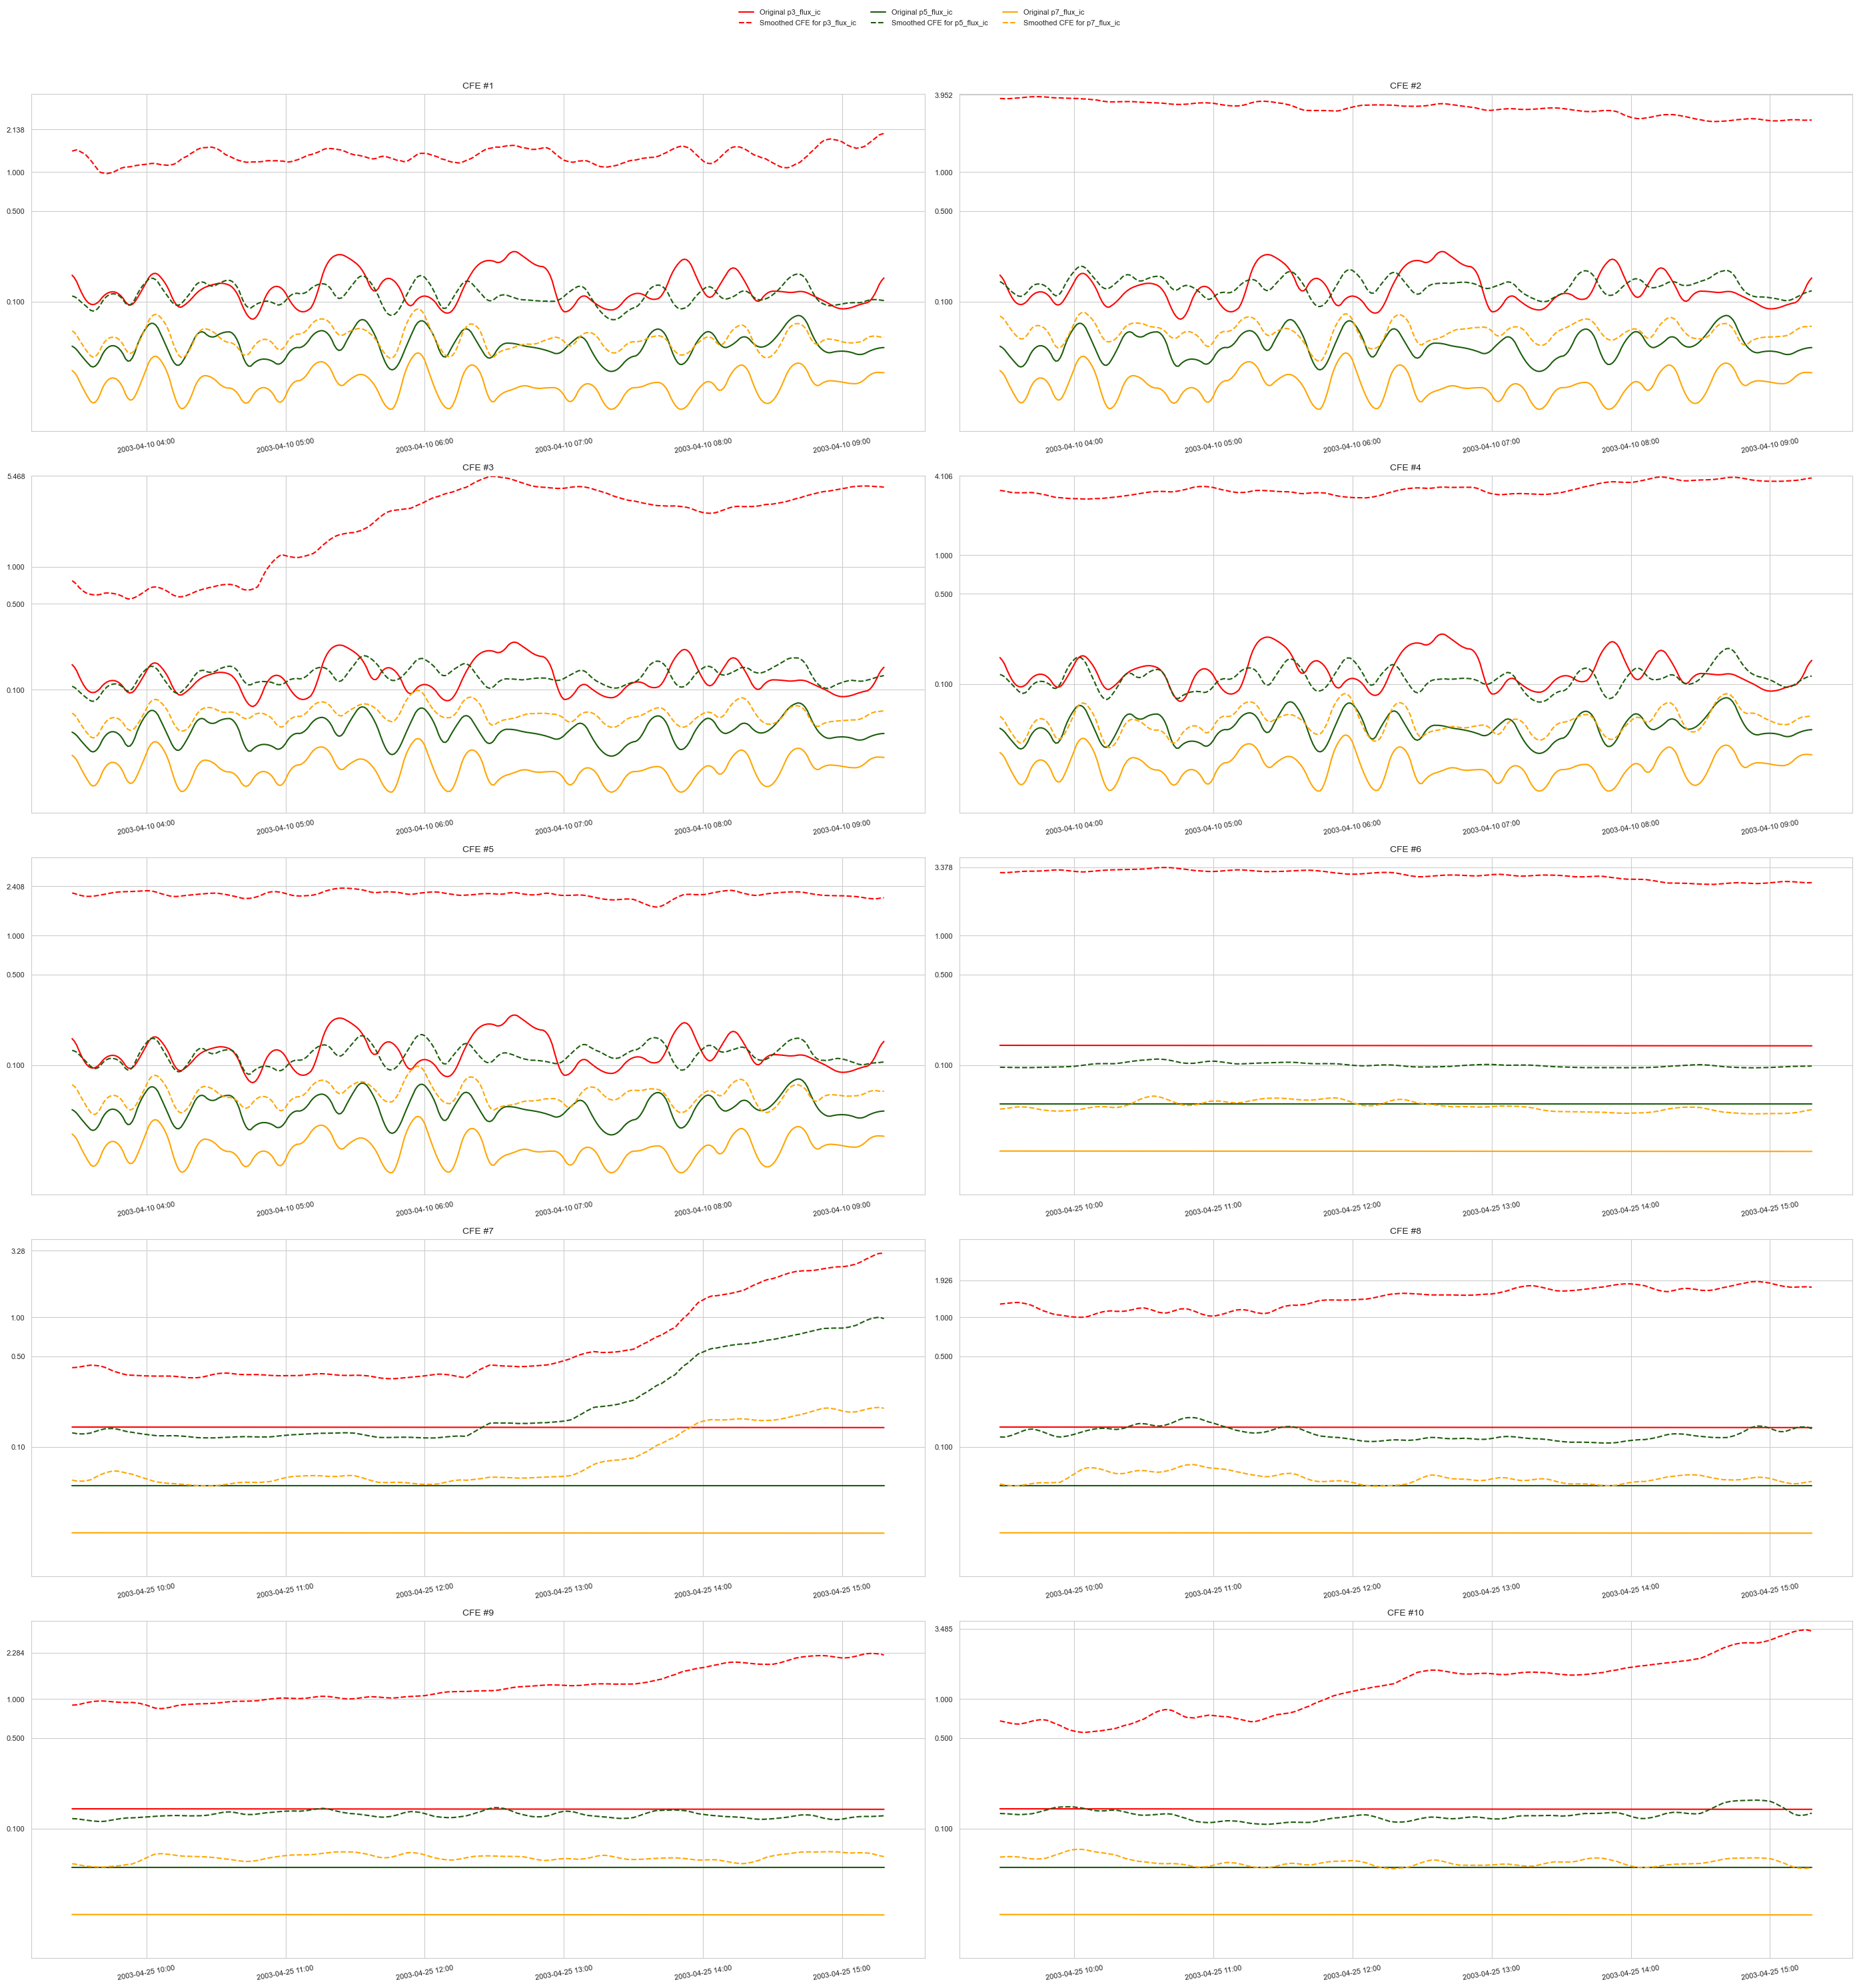

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

window_size = 10  # Smoothing window

fig, axs = plt.subplots(5, 2, figsize=(28, 30), facecolor='white')
axs = axs.flatten()  # Flatten for easy iteration

for cfe_idx in range(10):
    csv_path = os.path.join('../data/raw/data/', exp_cfs_df.iloc[cfe_idx]["filename"])

    sample_cfe = exp_cfs_df.iloc[cfe_idx].drop(["filename","method","instance_id"])

    # p3
    flux_type = 'p3_flux_ic'
    df_obs, final_series_p3, original_p3, min_y_p3, max_y_p3 = get_pertubed_series(
        csv_path, sample_cfe=sample_cfe, flux_type=flux_type, slices=slices,
        start_offset_min=300, end_offset_min=660)
    original_p3_smooth = original_p3.rolling(window=window_size, center=True).mean()
    final_series_p3_smooth = pd.Series(final_series_p3).rolling(window=window_size, center=True).mean()

    # p5
    flux_type = 'p5_flux_ic'
    df_obs_1, final_series_p5, original_p5, min_y_p5, max_y_p5 = get_pertubed_series(
        csv_path, sample_cfe=sample_cfe, flux_type=flux_type, slices=slices,
        start_offset_min=300, end_offset_min=660)
    original_p5_smooth = original_p5.rolling(window=window_size, center=True).mean()
    final_series_p5_smooth = pd.Series(final_series_p5).rolling(window=window_size, center=True).mean()

    # p7
    flux_type = 'p7_flux_ic'
    df_obs_2, final_series_p7, original_p7, min_y_p7, max_y_p7 = get_pertubed_series(
        csv_path, sample_cfe=sample_cfe, flux_type=flux_type, slices=slices,
        start_offset_min=300, end_offset_min=660)
    original_p7_smooth = original_p7.rolling(window=window_size, center=True).mean()
    final_series_p7_smooth = pd.Series(final_series_p7).rolling(window=window_size, center=True).mean()

    global_max_y = max(max_y_p3, max_y_p5, max_y_p7)
    i+=1
    ax = axs[i]
    ax.set_facecolor('white')

    # Plot lines
    ax.plot(df_obs['time_stamp'], original_p3_smooth, label="Original p3_flux_ic", color="#FF0000")
    ax.plot(df_obs['time_stamp'], final_series_p3_smooth, label="DiCE generated CFE for p3_flux_ic", color="#FF0000", linestyle='dashed')
    ax.plot(df_obs_1['time_stamp'], original_p5_smooth, label="Original p5_flux_ic", color="#1b5c0c")
    ax.plot(df_obs_1['time_stamp'], final_series_p5_smooth, label="DiCE generated CFE for p5_flux_ic", color="#1b5c0c", linestyle='dashed')
    ax.plot(df_obs_2['time_stamp'], original_p7_smooth, label="Original p7_flux_ic", color="#FFA500")
    ax.plot(df_obs_2['time_stamp'], final_series_p7_smooth, label="DiCE generated CFE for p7_flux_ic", color="#FFA500", linestyle='dashed')
    #
    # ax.set_xlabel("Period of Observation", fontsize=9)
    # ax.set_ylabel("Particle Flux Unit (log scale)", fontsize=9)
    ax.set_yscale('log')
    ax.set_ylim(bottom=0.01, top=4)
    ax.set_yticks([0.1, 0.5, 1, global_max_y])
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.setp(ax.get_xticklabels(), rotation=10, ha='center', fontsize=8)
    plt.setp(ax.get_yticklabels(), fontsize=8)
    # if cfe_idx == 0:
    #     ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, frameon=False, fontsize=8)
    ax.set_title(f'CFE #{cfe_idx + 1} for SEP_EVENT=={class_label}', fontsize=10)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.995),  # Centered above the grid
    ncol=3,
    frameon=False,
    fontsize=8
)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the legend at the top
plt.show()

